# Exploring the Vehicles Dataset

In [1]:
# import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import geopandas as gpd
%matplotlib inline

I'm going to start with an overview of the dataset:

In [2]:
vehicles_df = pd.read_csv("vehicles.csv")
vehicles_df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,...,vin,drive,size,type,paint_color,description,county,state,lat,long
0,palm springs,3400,2002.0,volkswagen,jetta gls,excellent,4 cylinders,gas,100000.0,clean,...,WVWSK61J62W209823,NaN,NaN,wagon,NaN,This 2002 Volkswagen Jetta GLS Wagon is simply...,NaN,ca,33.7451,-116.3520
1,salem,6300,2004.0,chevrolet,silverado 2500 crew cab,NaN,8 cylinders,gas,208942.0,clean,...,1GCHK23U94F144317,4wd,NaN,pickup,white,We want to let you know up front that Synergiz...,NaN,or,44.9225,-123.3200
2,long island,9997,2011.0,nissan,xterra,excellent,NaN,gas,125666.0,clean,...,5N1AN0NWXBC502031,NaN,NaN,NaN,NaN,Year : 2011 \t\t Make : NISSAN \t\t\tMode...,NaN,ny,40.8004,-73.0058
3,amarillo,21504,2017.0,chevrolet,malibu,NaN,4 cylinders,gas,24218.0,clean,...,NaN,fwd,mid-size,sedan,red,Use this link to see more information on this ...,NaN,tx,35.1773,-101.7940
4,inland empire,28900,2009.0,cadillac,cts-v,excellent,8 cylinders,gas,61000.0,clean,...,NaN,rwd,mid-size,sedan,silver,"2009 CTS-V, FAST! Awesome car, super clean, we...",NaN,ca,33.9748,-117.5580


The dataset contains 26988 registers and 21 columns:

In [3]:
vehicles_df.shape

(26988, 21)

Let's read and merge the other datasets.

From those we have 231 duplicated rows, redundant information is not useful, therefore I'm goign to proceed to discard it.

In [4]:
vehicles_df.duplicated().sum()

231

In [5]:
vehicles_df.drop_duplicates(inplace=True)

This slightly reduced the dataset to 26757 samples:

In [6]:
vehicles_df.shape

(26757, 21)

Here is a description of every column in the dataset, I'm going to highlight the ones that I consider useful for creating a predictive model:
- region: City where the vehicle is located. (String, Categorical feature)
- ***price: Price assigned to the car by the dealership (Float, Numerical Target Value)***
- ***year: Year when the car was produced (Int, numerical feature)***
- ***manufacturer: Brand of the car, company that produced it. (String, categorical feature) (Tesla, Ford, Ferrari)***
- ***model: Reference, particular version of a car (String, Categorical feature) (Aventador, Diablo)***
- ***condition: Evaluation of the current state of the car (String, Categorical feature) (New, Like new, Excellent, Good,Fair, Salvage)***
- ***cylinders: Place inside the combustion engine where the fuel is burned and movement is generated (Int, Numerica Feature)***
- ***fuel: Energy source of the car (String, Categorical feature) (Gas, Diesel, Hybrid, Electric)***
- ***odometer: Device that measures how many miles the car has been driven. (Int, Numerical Feature)***
- ***title_status: Status or lien of the vehicle, establishes if pre-conditions and ownership information of the vehicle. (Clean, Rebuilt, Salvage, Lien, Missing, Parts Missing) (String, Categortical Feature)***
- ***transmission: It's the system that transfers the power from the engine to the wheels. (String, Categorical Feature) (Automatic, Manual, Other)***
- vin: Vehicle identification number, car's id. (String, Categorical Feature)
- ***drive: Location of wheels that receive the power of the engine. (4wd, fwd, rwd) (String, Categorical Feature)***
- ***size: How big the car is. (Full-size Mid-size, Compact, Sub-compact) (String, Categorical Feature)***
- ***type: Car design. (Sedan, SUV, Pickup, Truck, Coupe, Hatchback, Van, Wagon, Convertible, Mini-Van, Offroad, Bus) (String, Categorical Feature)***
- paint_color: Car's color (Red, Blue, etc..)
- ***description: Additional text information about the car. (String, Text)***
- county: County where the car is located (Only null values, therefore not used.)
- state: State where the car is located. (Valid information but not relevant for the model)
- lat: Latitude where the car is located.
- long: Longitud where the car is located.

Let's check the location of all of these cars in the US map. 

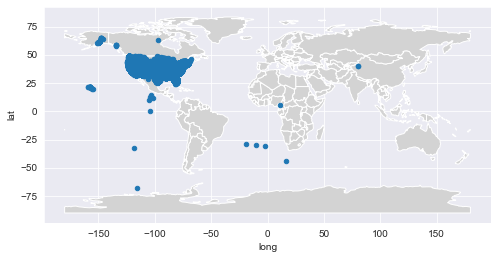

In [7]:
fig, ax = plt.subplots(figsize=(8,6))

countries = gpd.read_file(  
     gpd.datasets.get_path("naturalearth_lowres"))

countries.plot(color="lightgrey", ax=ax)

vehicles_df.plot(x="long", y="lat", kind="scatter", ax=ax)
plt.show()

There are different spots in the map in a different place than the regular map of the US that I know, some of them might be US territories but other could be just errors or cars located very far away from the country. 

## Dropping useless data for ML Model
Since the goal of the project is to predict the price of the car,  I'm discarding features that I don't consider useful for creating the predicting the model. 

In [8]:
data = vehicles_df.drop(
    columns=[
        "region", 
        "vin", 
        "paint_color", 
        "county", 
        "state", 
        "lat", 
        "long"
    ]
)

Once the features are defined, is time to check null values in every column:

In [10]:
data.isnull().sum()

price               0
year               49
manufacturer     1163
model             415
condition       11538
cylinders       11188
fuel              167
odometer         4899
title_status      136
transmission      236
drive            7903
size            18475
type             7063
description         3
dtype: int64

This information could be clearer displayed as percentages:

In [11]:
data.isnull().sum() * 100 / len(data)

price            0.000000
year             0.183130
manufacturer     4.346526
model            1.550996
condition       43.121426
cylinders       41.813357
fuel             0.624136
odometer        18.309227
title_status     0.508278
transmission     0.882012
drive           29.536196
size            69.047352
type            26.396831
description      0.011212
dtype: float64

I need to be extra carefull at how I'm handling the absence of missing data in the following features:

- condition (43%)
- cylinders (41%)
- odometer (18.5%)
- drive (29%)
- size (69%)
- type (26.5%)

Now let's check every single column at the time, to check for corectness on it's values and deal with missing data.

# Data Cleaning

I'm going over every single column of the dataset to check for proper values and cleaning strategy.

1. Price

This column has no missing value, let's just check for range.

In [12]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
data.price.describe()

count        26757.000
mean         55515.446
std        6825105.576
min              0.000
25%           4495.000
50%           9900.000
75%          17950.000
max     1116080943.000
Name: price, dtype: float64

It seems that some of the rows have price 0 value, at first sight it might seem like they are outliers or corrupted data, but getting that price is actually possible in the US.

In [13]:
data.query("price == 0").shape[0]

2248

There are also some outliers, a Honda Civic from 2012 that has a price of one houndred and eleven million dollars (1116080943) 😱. That is clearly an outlier that is going to affect my expected prices, therefore I'm going to delete it, along with other cars with prices higher than a million dollars.

In [14]:
data.query("price > 1_000_000")

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,description
1449,1234567,1987.000,gmc,sierra,excellent,8 cylinders,gas,nan,clean,automatic,rwd,NaN,NaN,Two owner. Interior redone. New radio and spea...
12933,1234567,1991.000,ford,mustang,good,8 cylinders,gas,nan,clean,manual,rwd,NaN,NaN,"91 Ford Mustang, GT-40,E303 cam, BBK exhaust, ..."
19141,1116080943,2012.000,honda,civic,excellent,NaN,gas,98090.000,clean,automatic,fwd,NaN,coupe,2012 Honda Civic LX Coupe 2D Coupe Ready To ...
23703,28003500,2007.000,chevrolet,impala lt,good,6 cylinders,gas,2000.000,clean,automatic,fwd,NaN,NaN,07 CHEVY IMPALA LT 3.5L V6 200K MILES PWR WIND...


I'm going to take into consideration the prices are smaller than a million dollars:

In [15]:
data = data.query("price < 1_000_000")
print(data.shape)
data.head()

(26753, 14)


,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,description
0,3400,2002.000,volkswagen,jetta gls,excellent,4 cylinders,gas,100000.000,clean,automatic,NaN,NaN,wagon,This 2002 Volkswagen Jetta GLS Wagon is simply...
1,6300,2004.000,chevrolet,silverado 2500 crew cab,NaN,8 cylinders,gas,208942.000,clean,automatic,4wd,NaN,pickup,We want to let you know up front that Synergiz...
2,9997,2011.000,nissan,xterra,excellent,NaN,gas,125666.000,clean,automatic,NaN,NaN,NaN,Year : 2011 \t\t Make : NISSAN \t\t\tMode...
3,21504,2017.000,chevrolet,malibu,NaN,4 cylinders,gas,24218.000,clean,automatic,fwd,mid-size,sedan,Use this link to see more information on this ...
4,28900,2009.000,cadillac,cts-v,excellent,8 cylinders,gas,61000.000,clean,automatic,rwd,mid-size,sedan,"2009 CTS-V, FAST! Awesome car, super clean, we..."


Let's check the price distribution once again:

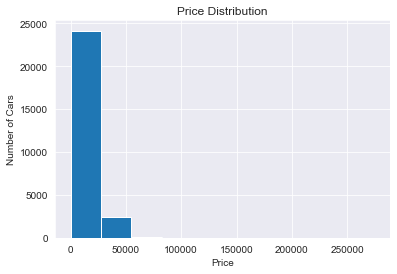

In [16]:
data.price.hist()
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Number of Cars");

2. Year

In [17]:
data.year.describe()

count   26704.000
mean     2009.936
std         8.811
min      1900.000
25%      2007.000
50%      2012.000
75%      2015.000
max      2021.000
Name: year, dtype: float64

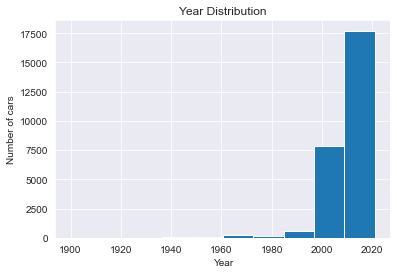

In [18]:
data.year.hist()
plt.title("Year Distribution")
plt.xlabel("Year")
plt.ylabel("Number of cars");

This column seems to be fine. Since almost 2% is missing and the year is such an important feature, I decided to remove all the rows where I don't have information about the year of the car. 

In [19]:
mask = data['year'].notna()
data = data[mask]

3. Manufacturer

There are 41 unique car manufacturers in this dataset.

In [20]:
data.manufacturer.unique().shape[0]

41

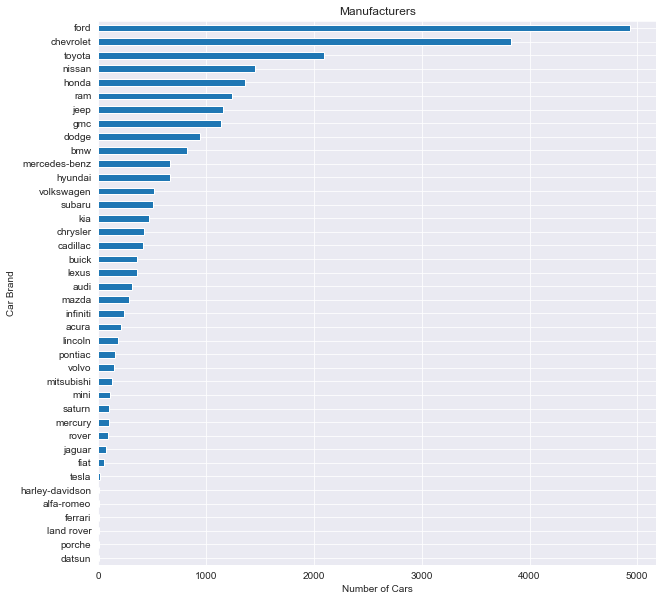

In [21]:
plt.figure(figsize=(10, 10))
data.manufacturer.value_counts(ascending=True).plot(kind="barh")
plt.title("Manufacturers")
plt.ylabel("Car Brand")
plt.xlabel("Number of Cars");

In [22]:
mask = data.manufacturer.notna()
data = data[mask]

4. Model

There exists 5509 different models in this dataset, I'm afrid the high cardinality of this feature won't allow me to make use of it, therefore I'm going to discard it. 

In [23]:
data.model.unique().shape[0]

5509

In [24]:
data.model.value_counts().nlargest(10)

f-150             589
silverado 1500    329
1500              328
silverado         283
civic             207
altima            204
accord            198
wrangler          193
camry             192
2500              189
Name: model, dtype: int64

In [25]:
data.drop(columns=["model"], inplace=True)

5. Condition

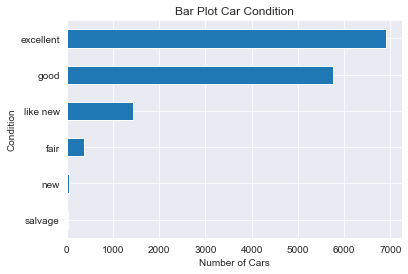

In [26]:
data.condition.value_counts(ascending=True).plot(kind="barh")
plt.title("Bar Plot Car Condition")
plt.ylabel("Condition")
plt.xlabel("Number of Cars");

In [27]:
mask = data.condition.notna()
data = data[mask]

6. Cylinders

The data type of the cylinders should be numeric and it seems it a string instead, it's required a small processing to clean it up. 

In [28]:
data.cylinders.value_counts()

6 cylinders     4130
8 cylinders     3589
4 cylinders     3374
10 cylinders     134
5 cylinders      100
3 cylinders       23
other             22
12 cylinders       6
Name: cylinders, dtype: int64

In [29]:
mask = data.cylinders.notna()
data = data[mask]

In [30]:
data.cylinders.replace({"other": 0}, inplace=True)

In [31]:
def cylinder_preprocessing(input_string):
    if type(input_string) is not str:
        return input_string
    int_string = input_string[0:2]
    return int(int_string)

data.cylinders = data.cylinders.apply(cylinder_preprocessing)
data.cylinders.value_counts()

6     4130
8     3589
4     3374
10     134
5      100
3       23
0       22
12       6
Name: cylinders, dtype: int64

7. Fuel

There is only one null value, it's ok to discard it. 

In [32]:
data.fuel.unique()

array(['gas', 'other', 'diesel', 'hybrid', 'electric', nan], dtype=object)

In [33]:
mask = data.fuel.notna()
data = data[mask]

In [34]:
data.fuel.value_counts()

gas         10456
diesel        674
other         120
hybrid        114
electric       13
Name: fuel, dtype: int64

8. Odometer



In [35]:
mask = data.odometer.notna()
data = data[mask]

In [36]:
data.odometer.describe()

count      9913.000
mean     109844.264
std      105796.991
min           0.000
25%       59257.000
50%      103726.000
75%      146545.000
max     4710000.000
Name: odometer, dtype: float64

In [37]:
data.isnull().sum()

price              0
year               0
manufacturer       0
condition          0
cylinders          0
fuel               0
odometer           0
title_status       0
transmission       2
drive           1298
size            4293
type            1130
description        0
dtype: int64

9. Title Status



In [38]:
data.title_status.value_counts()

clean         9356
rebuilt        295
salvage        165
lien            92
missing          4
parts only       1
Name: title_status, dtype: int64

10. Transmission

In [39]:
data.transmission.value_counts()

automatic    8621
manual        655
other         635
Name: transmission, dtype: int64

In [40]:
mask = data.transmission.notna()
data = data[mask]

11. Drive

In [41]:
data.drive.value_counts()

4wd    3685
fwd    2862
rwd    2066
Name: drive, dtype: int64

In [42]:
mask = data.drive.notna()
data = data[mask]

12. Size

In [43]:
data["size"].isnull().sum()

3202

In [44]:
data.drop(columns=["size"], inplace=True)

13. Type


In [45]:
data.type.value_counts()

sedan          1956
SUV            1903
truck          1208
pickup          931
coupe           538
hatchback       273
van             272
wagon           214
convertible     180
mini-van        173
other           121
offroad          26
bus               4
Name: type, dtype: int64

In [46]:
mask = data.type.notna()
data = data[mask]

14. Description

This feature won't be considered for the first version of this model.

In [47]:
data.drop(columns=["description"], inplace=True)

Final Dataset

In [48]:
data.shape

(7799, 11)

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7799 entries, 4 to 26983
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         7799 non-null   int64  
 1   year          7799 non-null   float64
 2   manufacturer  7799 non-null   object 
 3   condition     7799 non-null   object 
 4   cylinders     7799 non-null   int64  
 5   fuel          7799 non-null   object 
 6   odometer      7799 non-null   float64
 7   title_status  7799 non-null   object 
 8   transmission  7799 non-null   object 
 9   drive         7799 non-null   object 
 10  type          7799 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 731.2+ KB


In [52]:
data.isnull().sum()

price           0
year            0
manufacturer    0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
dtype: int64

In [54]:
data.duplicated().sum()

351

In [55]:
data.drop_duplicates(inplace=True)

In [57]:
data.to_csv("clean_vehicles.csv", index=False)